In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings 
warnings.filterwarnings("ignore")

# Problem 1 - Sales Data Analysis

In [2]:
ds=pd.read_csv('C:/Users/dheepig/Desktop/Dheepika/Great Lakes/Session 10- Marketing and Retail/Project/Milestone -2/Datasets/dataset_group.csv')
ds.head()

,Date,Order_id,Product
0,01-01-2018,1,yogurt
1,01-01-2018,1,pork
2,01-01-2018,1,sandwich bags
3,01-01-2018,1,lunch meat
4,01-01-2018,1,all- purpose


# Question 1. Agenda & Executive Summary of the data

In [3]:
ds.tail()

,Date,Order_id,Product
20636,25-02-2020,1138,soda
20637,25-02-2020,1138,paper towels
20638,26-02-2020,1139,soda
20639,26-02-2020,1139,laundry detergent
20640,26-02-2020,1139,shampoo


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641 entries, 0 to 20640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      20641 non-null  object
 1   Order_id  20641 non-null  int64 
 2   Product   20641 non-null  object
dtypes: int64(1), object(2)
memory usage: 483.9+ KB


In [5]:
row, col = ds.shape
print("There are total {}".format(row), "rows and {}".format(col), "columns in the dataset")

There are total 20641 rows and 3 columns in the dataset


In [6]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Order_id,20641.0,575.986289,328.557078,1.0,292.0,581.0,862.0,1139.0


In [7]:
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,20641,603,08-02-2019,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order_id,20641.0,NaN,NaN,NaN,575.986289,328.557078,1.0,292.0,581.0,862.0,1139.0
Product,20641,37,poultry,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dup=ds.duplicated().sum()
print("There are total of {}".format(dup), "duplicate records in the dataset")

There are total of 4730 duplicate records in the dataset


In [9]:
dups=ds.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 4730


In [10]:
ds = ds.drop_duplicates()

In [11]:
dups=ds.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [12]:
ds['Product'] = ds['Product'].str.lower()

In [13]:
ds

,Date,Order_id,Product
0,01-01-2018,1,yogurt
1,01-01-2018,1,pork
2,01-01-2018,1,sandwich bags
3,01-01-2018,1,lunch meat
4,01-01-2018,1,all- purpose
...,...,...,...
20634,25-02-2020,1138,soda
20637,25-02-2020,1138,paper towels
20638,26-02-2020,1139,soda
20639,26-02-2020,1139,laundry detergent


In [14]:
ds = ds.drop(ds[ds.Product == 'none'].index)

In [15]:
ds.head()

,Date,Order_id,Product
0,01-01-2018,1,yogurt
1,01-01-2018,1,pork
2,01-01-2018,1,sandwich bags
3,01-01-2018,1,lunch meat
4,01-01-2018,1,all- purpose


In [16]:
ds.nunique()

Date         603
Order_id    1139
Product       37
dtype: int64

In [17]:
ds[['Product']].nunique()

Product    37
dtype: int64

In [18]:
for column in ds[['Product']]:
    print(column.upper(),': ',ds[column].nunique())
    print(ds[column].value_counts().sort_values())
    print('\n')

PRODUCT :  37
hand soap                       394
sandwich loaves                 398
flour                           402
pork                            405
sugar                           411
paper towels                    413
butter                          419
sandwich bags                   419
shampoo                         420
tortillas                       421
fruits                          422
ketchup                         423
pasta                           423
spaghetti sauce                 425
beef                            427
all- purpose                    427
mixes                           428
individual meals                428
juice                           429
laundry detergent               431
toilet paper                    431
soap                            432
coffee/tea                      432
milk                            433
aluminum foil                   438
yogurt                          438
bagels                          439
dishwashing li

In [19]:
ds.Product.unique()

array(['yogurt', 'pork', 'sandwich bags', 'lunch meat', 'all- purpose',
       'flour', 'soda', 'butter', 'beef', 'aluminum foil', 'dinner rolls',
       'shampoo', 'mixes', 'soap', 'laundry detergent', 'ice cream',
       'toilet paper', 'hand soap', 'waffles', 'cheeses', 'milk',
       'dishwashing liquid/detergent', 'individual meals', 'cereals',
       'tortillas', 'spaghetti sauce', 'ketchup', 'sandwich loaves',
       'poultry', 'bagels', 'eggs', 'juice', 'pasta', 'paper towels',
       'coffee/tea', 'fruits', 'sugar'], dtype=object)

In [20]:
ds.dtypes

Date        object
Order_id     int64
Product     object
dtype: object

In [21]:
ds.skew(axis=0,skipna=True)

Order_id   -0.023884
dtype: float64

In [22]:
ds.kurtosis(axis=0,skipna=True)

Order_id   -1.186942
dtype: float64

In [23]:
for column in ds.columns:
    if ds[column].dtype !='object':
        median=ds[column].median()
        ds[column]=ds[column].fillna(median)
ds.isnull().sum()  

Date        0
Order_id    0
Product     0
dtype: int64

# 2. Exploratory Analysis and Inferences

In [24]:
def detect_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [25]:
lr1,ur1=detect_outlier(ds['Order_id'])
print("lower range",lr1,"upper range",ur1)

lower range -564.75 upper range 1713.25


In [26]:
num = ds.select_dtypes(include=['int','float']).columns

In [27]:
def proportion(x):
        xs = pd.Series(sorted(ds[x]))
        Q3 = xs.quantile(q=0.75)
        Q1 = xs.quantile(q=0.25)
        IQR = Q3-Q1
        LR = Q1-(1.5*IQR)
        UR = Q3+(1.5*IQR)
        
        data = ds[x]
        count = 0
        for value in data:
            if (value<LR) or (value>UR):
                count += 1
            else:
                pass

        _proportion = round((count/len(ds[x]))*100,2)
        print('Outlier proportion: {}: {}%'.format(x, _proportion))

In [28]:
for i in num:
    proportion(i)

Outlier proportion: Order_id: 0.0%


In [29]:
corr1=ds.corr()
round(corr1,2)

,Order_id
Order_id,1.0


Text(0.5, 1.0, 'Box plot of Data')

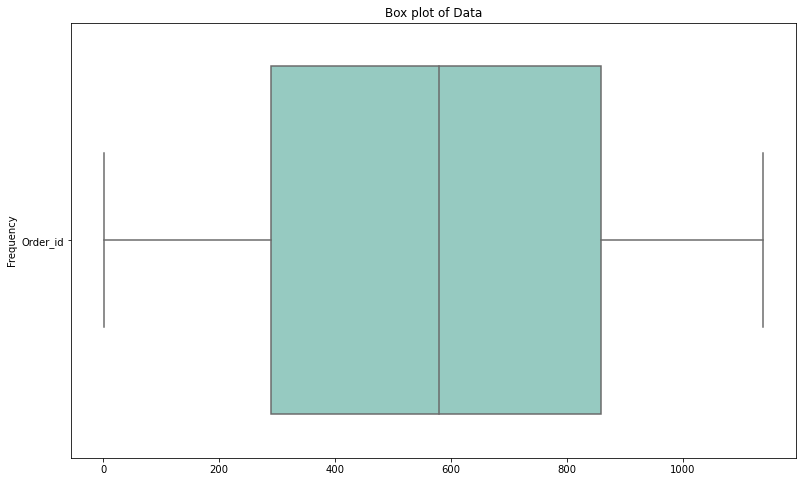

In [30]:
plt.figure(figsize=(13,8))
sns.boxplot(data=ds,orient="h", palette="Set3")
plt.ylabel("Frequency")
plt.title("Box plot of Data")

In [31]:
for column in ds.columns:
    if ds[column].dtype=='object':
        print(column.upper(),': ',ds[column].nunique())
        print(ds[column].value_counts().sort_values())
        print('\n')

DATE :  603
26-02-2020      3
24-09-2018      3
04-04-2018      4
11-03-2019      4
05-09-2019      4
             ... 
01-03-2018     91
17-05-2018     92
06-03-2018     99
20-02-2019    106
08-02-2019    138
Name: Date, Length: 603, dtype: int64


PRODUCT :  37
hand soap                       394
sandwich loaves                 398
flour                           402
pork                            405
sugar                           411
paper towels                    413
butter                          419
sandwich bags                   419
shampoo                         420
tortillas                       421
fruits                          422
ketchup                         423
pasta                           423
spaghetti sauce                 425
beef                            427
all- purpose                    427
mixes                           428
individual meals                428
juice                           429
laundry detergent               431
toilet paper    

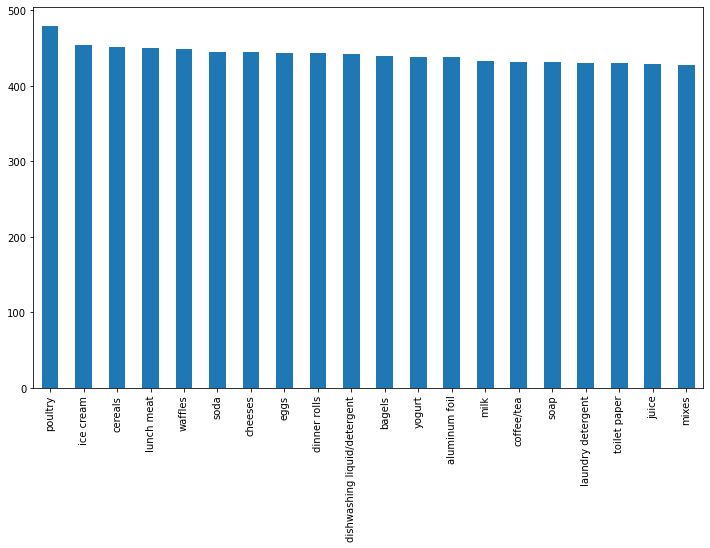

In [32]:
ds['Product'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar',figsize=(12,7));

# 3. Market Basket Analysis

In [33]:
basket=ds.groupby(['Order_id', 'Product'])['Product'].count().unstack().reset_index().fillna(0).set_index('Order_id')

In [34]:
basket.head()

Product,all- purpose,aluminum foil,bagels,beef,butter,cereals,cheeses,coffee/tea,dinner rolls,dishwashing liquid/detergent,...,sandwich loaves,shampoo,soap,soda,spaghetti sauce,sugar,toilet paper,tortillas,waffles,yogurt
Order_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [35]:
def encode_zero_one(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [36]:
basket=basket.applymap(encode_zero_one)

In [37]:
itemsets = apriori(basket, min_support = 0.01, use_colnames = True, low_memory=True)
itemsets

,support,itemsets
0,0.374890,(all- purpose)
1,0.384548,(aluminum foil)
2,0.385426,(bagels)
3,0.374890,(beef)
4,0.367867,(butter)
...,...,...
610567,0.010536,"(soap, spaghetti sauce, ketchup, sandwich bags..."
610568,0.011414,"(soap, waffles, spaghetti sauce, ketchup, sand..."
610569,0.010536,"(soap, shampoo, sandwich loaves, lunch meat, l..."
610570,0.011414,"(yogurt, shampoo, sandwich bags, lunch meat, m..."


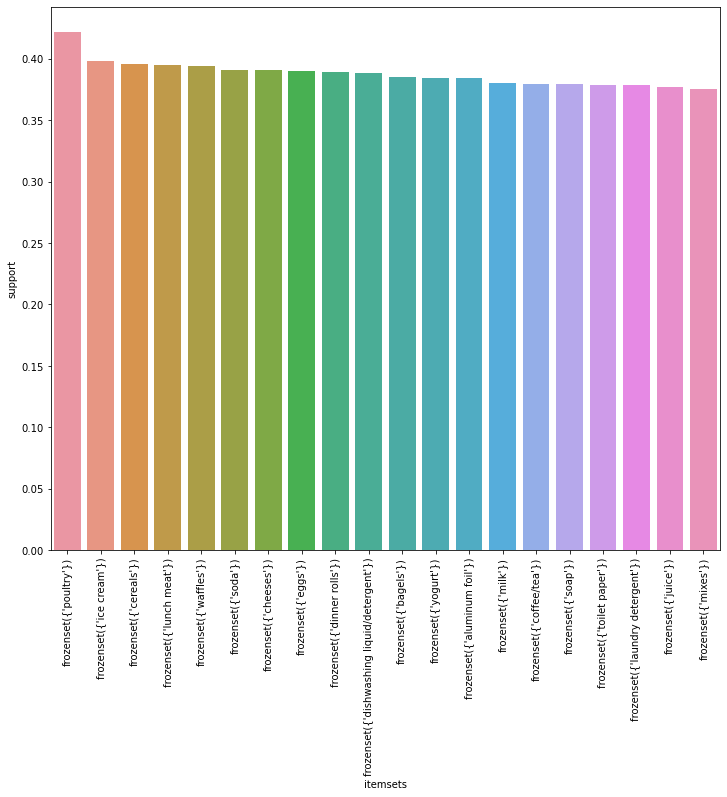

In [38]:
plt.figure(figsize=(12,10))
sns.barplot(itemsets.sort_values('support',ascending=False).iloc[0:20,1],
            itemsets.sort_values('support',ascending=False).iloc[0:20,0])
plt.xticks(rotation=90)
plt.show()

In [39]:
basket = association_rules(itemsets, metric ="lift")
basket = basket.sort_values(['lift','confidence'], ascending =[False, False])

In [40]:
basket.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21916487,"(sugar, ketchup, sandwich bags, all- purpose)","(soap, flour, laundry detergent)",0.023705,0.058824,0.011414,0.481481,8.185185,0.010019,1.815126
21916494,"(soap, flour, laundry detergent)","(sugar, ketchup, sandwich bags, all- purpose)",0.058824,0.023705,0.011414,0.194030,8.185185,0.010019,1.211329
21907032,"(fruits, coffee/tea, all- purpose, toilet paper)","(beef, cereals, butter)",0.022827,0.058824,0.010536,0.461538,7.846154,0.009193,1.747899
21907049,"(beef, cereals, butter)","(fruits, coffee/tea, all- purpose, toilet paper)",0.058824,0.022827,0.010536,0.179104,7.846154,0.009193,1.190374
22026356,"(individual meals, milk, ice cream, pork)","(shampoo, sandwich loaves, cereals)",0.020193,0.067603,0.010536,0.521739,7.717674,0.009170,1.949557
22026369,"(shampoo, sandwich loaves, cereals)","(individual meals, milk, ice cream, pork)",0.067603,0.020193,0.010536,0.155844,7.717674,0.009170,1.160694
22029884,"(ketchup, milk, lunch meat, cheeses)","(soap, coffee/tea, pork)",0.022827,0.065847,0.011414,0.500000,7.593333,0.009910,1.868306
22029897,"(soap, coffee/tea, pork)","(ketchup, milk, lunch meat, cheeses)",0.065847,0.022827,0.011414,0.173333,7.593333,0.009910,1.182064
21916488,"(sugar, ketchup, all- purpose, laundry detergent)","(soap, flour, sandwich bags)",0.025461,0.059701,0.011414,0.448276,7.508621,0.009893,1.704291
21916493,"(soap, flour, sandwich bags)","(sugar, ketchup, all- purpose, laundry detergent)",0.059701,0.025461,0.011414,0.191176,7.508621,0.009893,1.204885
